In [ ]:
import tensorflow as tf
import nltk
import numpy as np
import re
import math
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from utils_display import pc
from utils_display import nice_colorbar

In [3]:
random.seed(421)

### Text, corpus, and vocabulary

In [4]:
# Text
with open("datasets/animal_farm_george_orwell.txt", "r") as fid:
    text = fid.read()

In [5]:
# Corpus
sentences = nltk.tokenize.sent_tokenize(text)
random.shuffle(sentences)

corpus = []
for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.findall(r'\b\w+\b', sentence) 
    corpus.append(sentence)

number_of_sentences = len(corpus)
pc("Number of sentences", number_of_sentences)

Number of sentences: 1637


In [6]:
train_split = 0.9
number_of_train_sentences = int(train_split * number_of_sentences)
number_of_validation_sentences = number_of_sentences - number_of_train_sentences
pc("Number of train sentences", number_of_train_sentences)
pc("Number of validation sentences", number_of_validation_sentences)

Number of train sentences: 1473
Number of validation sentences: 164


In [7]:
number_of_example_sentences = 4
for index in range(number_of_example_sentences):
    pc("Index", index)
    print(sentences[index])
    print(corpus[index])
    print("-"*64)

Index: 0
From now onwards Animal Farm would engage in trade with the neighbouring farms: not, of course, for any commercial purpose, but simply in order to obtain certain materials which were urgently necessary.
['from', 'now', 'onwards', 'animal', 'farm', 'would', 'engage', 'in', 'trade', 'with', 'the', 'neighbouring', 'farms', 'not', 'of', 'course', 'for', 'any', 'commercial', 'purpose', 'but', 'simply', 'in', 'order', 'to', 'obtain', 'certain', 'materials', 'which', 'were', 'urgently', 'necessary']
----------------------------------------------------------------
Index: 1
Finally there came a night when the gale was so violent that the farm buildings rocked on their foundations and several tiles were blown off the roof of the barn.
['finally', 'there', 'came', 'a', 'night', 'when', 'the', 'gale', 'was', 'so', 'violent', 'that', 'the', 'farm', 'buildings', 'rocked', 'on', 'their', 'foundations', 'and', 'several', 'tiles', 'were', 'blown', 'off', 'the', 'roof', 'of', 'the', 'barn']
---

In [8]:
# Vocabulary
vocabulary = set([word for sentence in corpus for word in sentence])
vocabulary_size = len(vocabulary)
pc("Vocabulary size", vocabulary_size)

Vocabulary size: 3921


In [9]:
words_frequency = {}
for sentence in corpus:
    for word in sentence:
        if word in words_frequency:
            words_frequency[word] += 1
        else:
            words_frequency[word] = 1

words_frequency = sorted(words_frequency.items(), key=lambda x:x[1], reverse=True)

number_of_examples = 20
pc("{} most frequent words".format(number_of_examples), words_frequency[:number_of_examples])
pc("{} least frequent words".format(number_of_examples), words_frequency[-number_of_examples:])

20 most frequent words: [('the', 2211), ('and', 968), ('of', 902), ('to', 814), ('was', 633), ('a', 622), ('in', 544), ('had', 529), ('that', 453), ('it', 396), ('they', 345), ('he', 324), ('were', 290), ('his', 272), ('for', 264), ('animals', 248), ('on', 247), ('with', 231), ('at', 212), ('their', 197)]
20 least frequent words: [('composing', 1), ('forming', 1), ('semicircle', 1), ('gives', 1), ('minimum', 1), ('keeps', 1), ('luxuries', 1), ('thus', 1), ('1', 1), ('alter', 1), ('stores', 1), ('compensated', 1), ('emboldened', 1), ('collapse', 1), ('inventing', 1), ('bewilderment', 1), ('lacked', 1), ('expect', 1), ('peaceful', 1), ('spend', 1)]


In [10]:
word2index = {word: index for index, word in enumerate(vocabulary)}
index2word = {index: word for index, word in enumerate(vocabulary)}

In [11]:
number_of_example_entries = 4
pc("word2index", list(word2index.items())[:number_of_example_entries])
pc("index2word", list(index2word.items())[:number_of_example_entries])

word2index: [('feelings', 0), ('creatures', 1), ('handsome', 2), ('relating', 3)]
index2word: [(0, 'feelings'), (1, 'creatures'), (2, 'handsome'), (3, 'relating')]


In [12]:
def generate_input_and_label_pairs(sequences, context_window):    
    context_and_target_pairs = []
    inputs = []
    labels = []
    for sequence in sequences:
        for i in range(context_window, len(sequence) - context_window):
            context = sequence[i - context_window : i] + sequence[i + 1 : i + context_window + 1]
            target = sequence[i]
            context_and_target_pairs.append((context, target))
        
            inputs.append([word2index[word] for word in context])
            labels.append(word2index[target])

    inputs = np.asarray(inputs)
    labels = np.asarray(labels)
    
    return context_and_target_pairs, inputs, labels

In [13]:
context_window = 2
train_data, train_inputs, train_labels = generate_input_and_label_pairs(
    sequences=corpus[:number_of_train_sentences], context_window=context_window)

validation_data, validation_inputs, validation_labels = generate_input_and_label_pairs(
    sequences=corpus[number_of_train_sentences:], context_window=context_window)

pc("Number of training samples", len(train_data))
pc("Number of validation samples", len(validation_data))

Number of training samples: 21647
Number of validation samples: 2317


In [14]:
number_of_examples = 4
for index in range(number_of_examples):
    print("Label: {:<6} {:20} Input: {} ({})".format(
        train_labels[index], train_data[index][1], train_inputs[index], train_data[index][0]))

Label: 174    onwards              Input: [ 142 2598   40 2764] (['from', 'now', 'animal', 'farm'])
Label: 40     animal               Input: [2598  174 2764 3072] (['now', 'onwards', 'farm', 'would'])
Label: 2764   farm                 Input: [ 174   40 3072 3131] (['onwards', 'animal', 'would', 'engage'])
Label: 3072   would                Input: [  40 2764 3131  704] (['animal', 'farm', 'engage', 'in'])


### Model

In [15]:
embedding_dim = 20

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(vocabulary_size, activation="softmax")])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
number_of_epochs = 100
batch_size = 32

history = model.fit(
    train_inputs,
    train_labels,
    validation_data=(validation_inputs, validation_labels),
    epochs=number_of_epochs,
    batch_size=batch_size,
    verbose=False)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 4, 20)          │        78,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 20)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3921)           │        82,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,285 (1.84 MB)

 Trainable params: 160,761 (627.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 321,524 (1.23 MB)

### Results

In [19]:
word_embeddings = model.get_weights()[0]
number_of_examples = 4
for index in range(number_of_examples):
    embedding = word_embeddings[index]
    word = index2word[index]
    pc(word, embedding)

feelings: [ 0.543842    1.4849201   0.24241738 -0.67989147 -1.0223787  -0.05994451
  0.91024905  1.3596735   0.07624032 -0.41489956 -0.6734686   0.18111244
 -0.7132564   0.00456986 -2.0951629   0.9424469   1.2783372   0.03072863
 -0.6000418   0.1338413 ]
creatures: [-0.64097434  1.4558065   1.1441437  -1.0303718  -0.1744943  -2.250671
  1.0692865   0.02704279  1.9103997   0.3673373   0.6119139   0.50830203
  0.72918034 -0.75874513 -0.04536656 -0.44034588 -0.91791487 -0.3028498
 -0.05555026  1.2706242 ]
handsome: [-0.19479474 -0.9426642  -1.6133977  -2.4914644  -2.4142363  -1.9471209
 -0.35133603 -2.9105608   1.0065998  -2.938959   -1.6394362  -0.17002012
 -0.6654278  -2.6263196  -1.1038301  -0.9083447  -2.7255712  -1.6995071
 -1.6503814  -2.1281528 ]
relating: [ 1.0123854  -2.7603588   3.6895585  -1.8702536  -1.2162726   1.452825
  0.70145535  0.1237829   2.3665018   0.91952854  2.6665604  -1.846006
  0.26390386 -0.36369053 -0.5661394   0.14537384 -1.7929661  -0.7783445
 -2.3196123   0

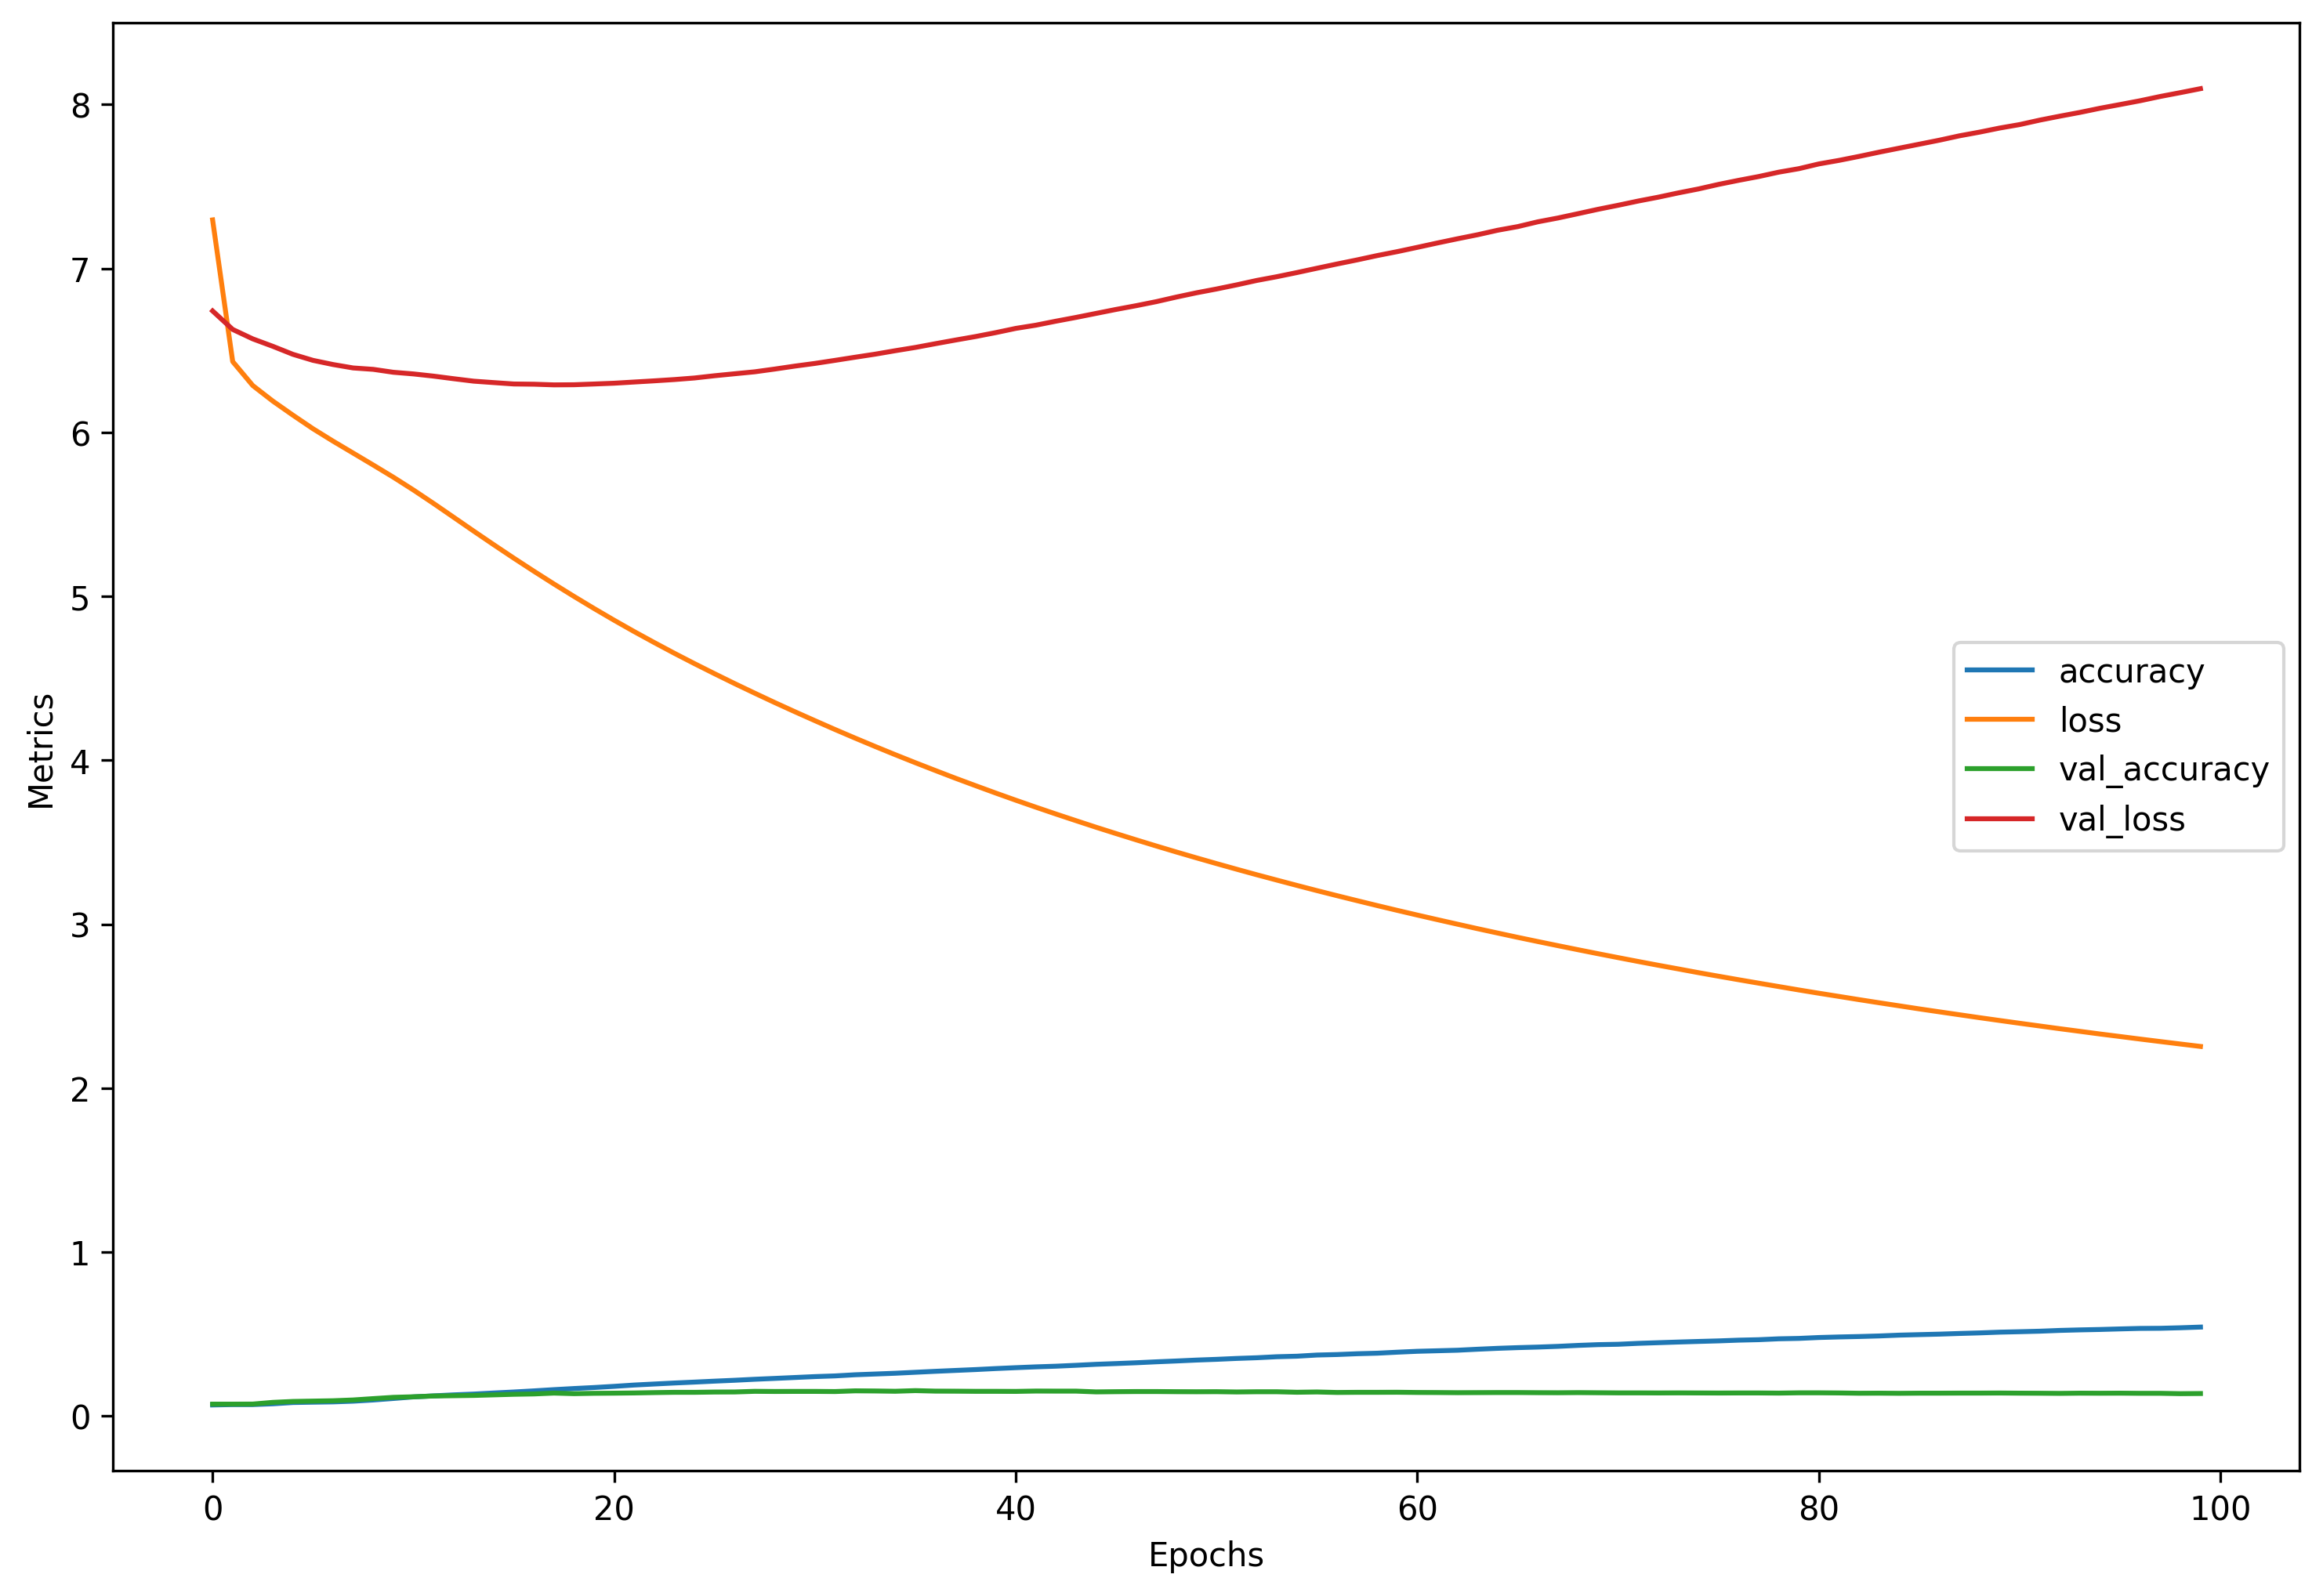

In [20]:
plt.rcParams["figure.dpi"] = 300
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

In [21]:
index = 150

input_context = validation_inputs[index]
input_label = validation_labels[index]
input_context = np.expand_dims(input_context, axis=0)

predicted_labels = model.predict(input_context)[0]

pc("Index", index, break_line=True)

pc("Input context (indices)", input_context[0])
pc("Input context (words)", [index2word[i] for i in input_context[0]], break_line=True)

pc("Input label (index)", input_label)
pc("Input label (word)", index2word[input_label], break_line=True)

sorted_indices = np.argsort(-predicted_labels)
number_of_example = 4
for i in range(number_of_examples):
    vocabulary_index = sorted_indices[i]
    msg = "{} (index: {}, prediction strength: {:.2f}".format(
        index2word[vocabulary_index], vocabulary_index, predicted_labels[vocabulary_index])
    pc("Predicted word", msg)    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Index: 150

Input context (indices): [2671 3400 2245 3400]
Input context (words): ['and', 'the', 'of', 'the']

Input label (index): 1955
Input label (word): rest

Predicted word: farm (index: 2764, prediction strength: 0.07
Predicted word: animals (index: 3236, prediction strength: 0.05
Predicted word: behaviour (index: 721, prediction strength: 0.05
Predicted word: windmill (index: 2225, prediction strength: 0.03


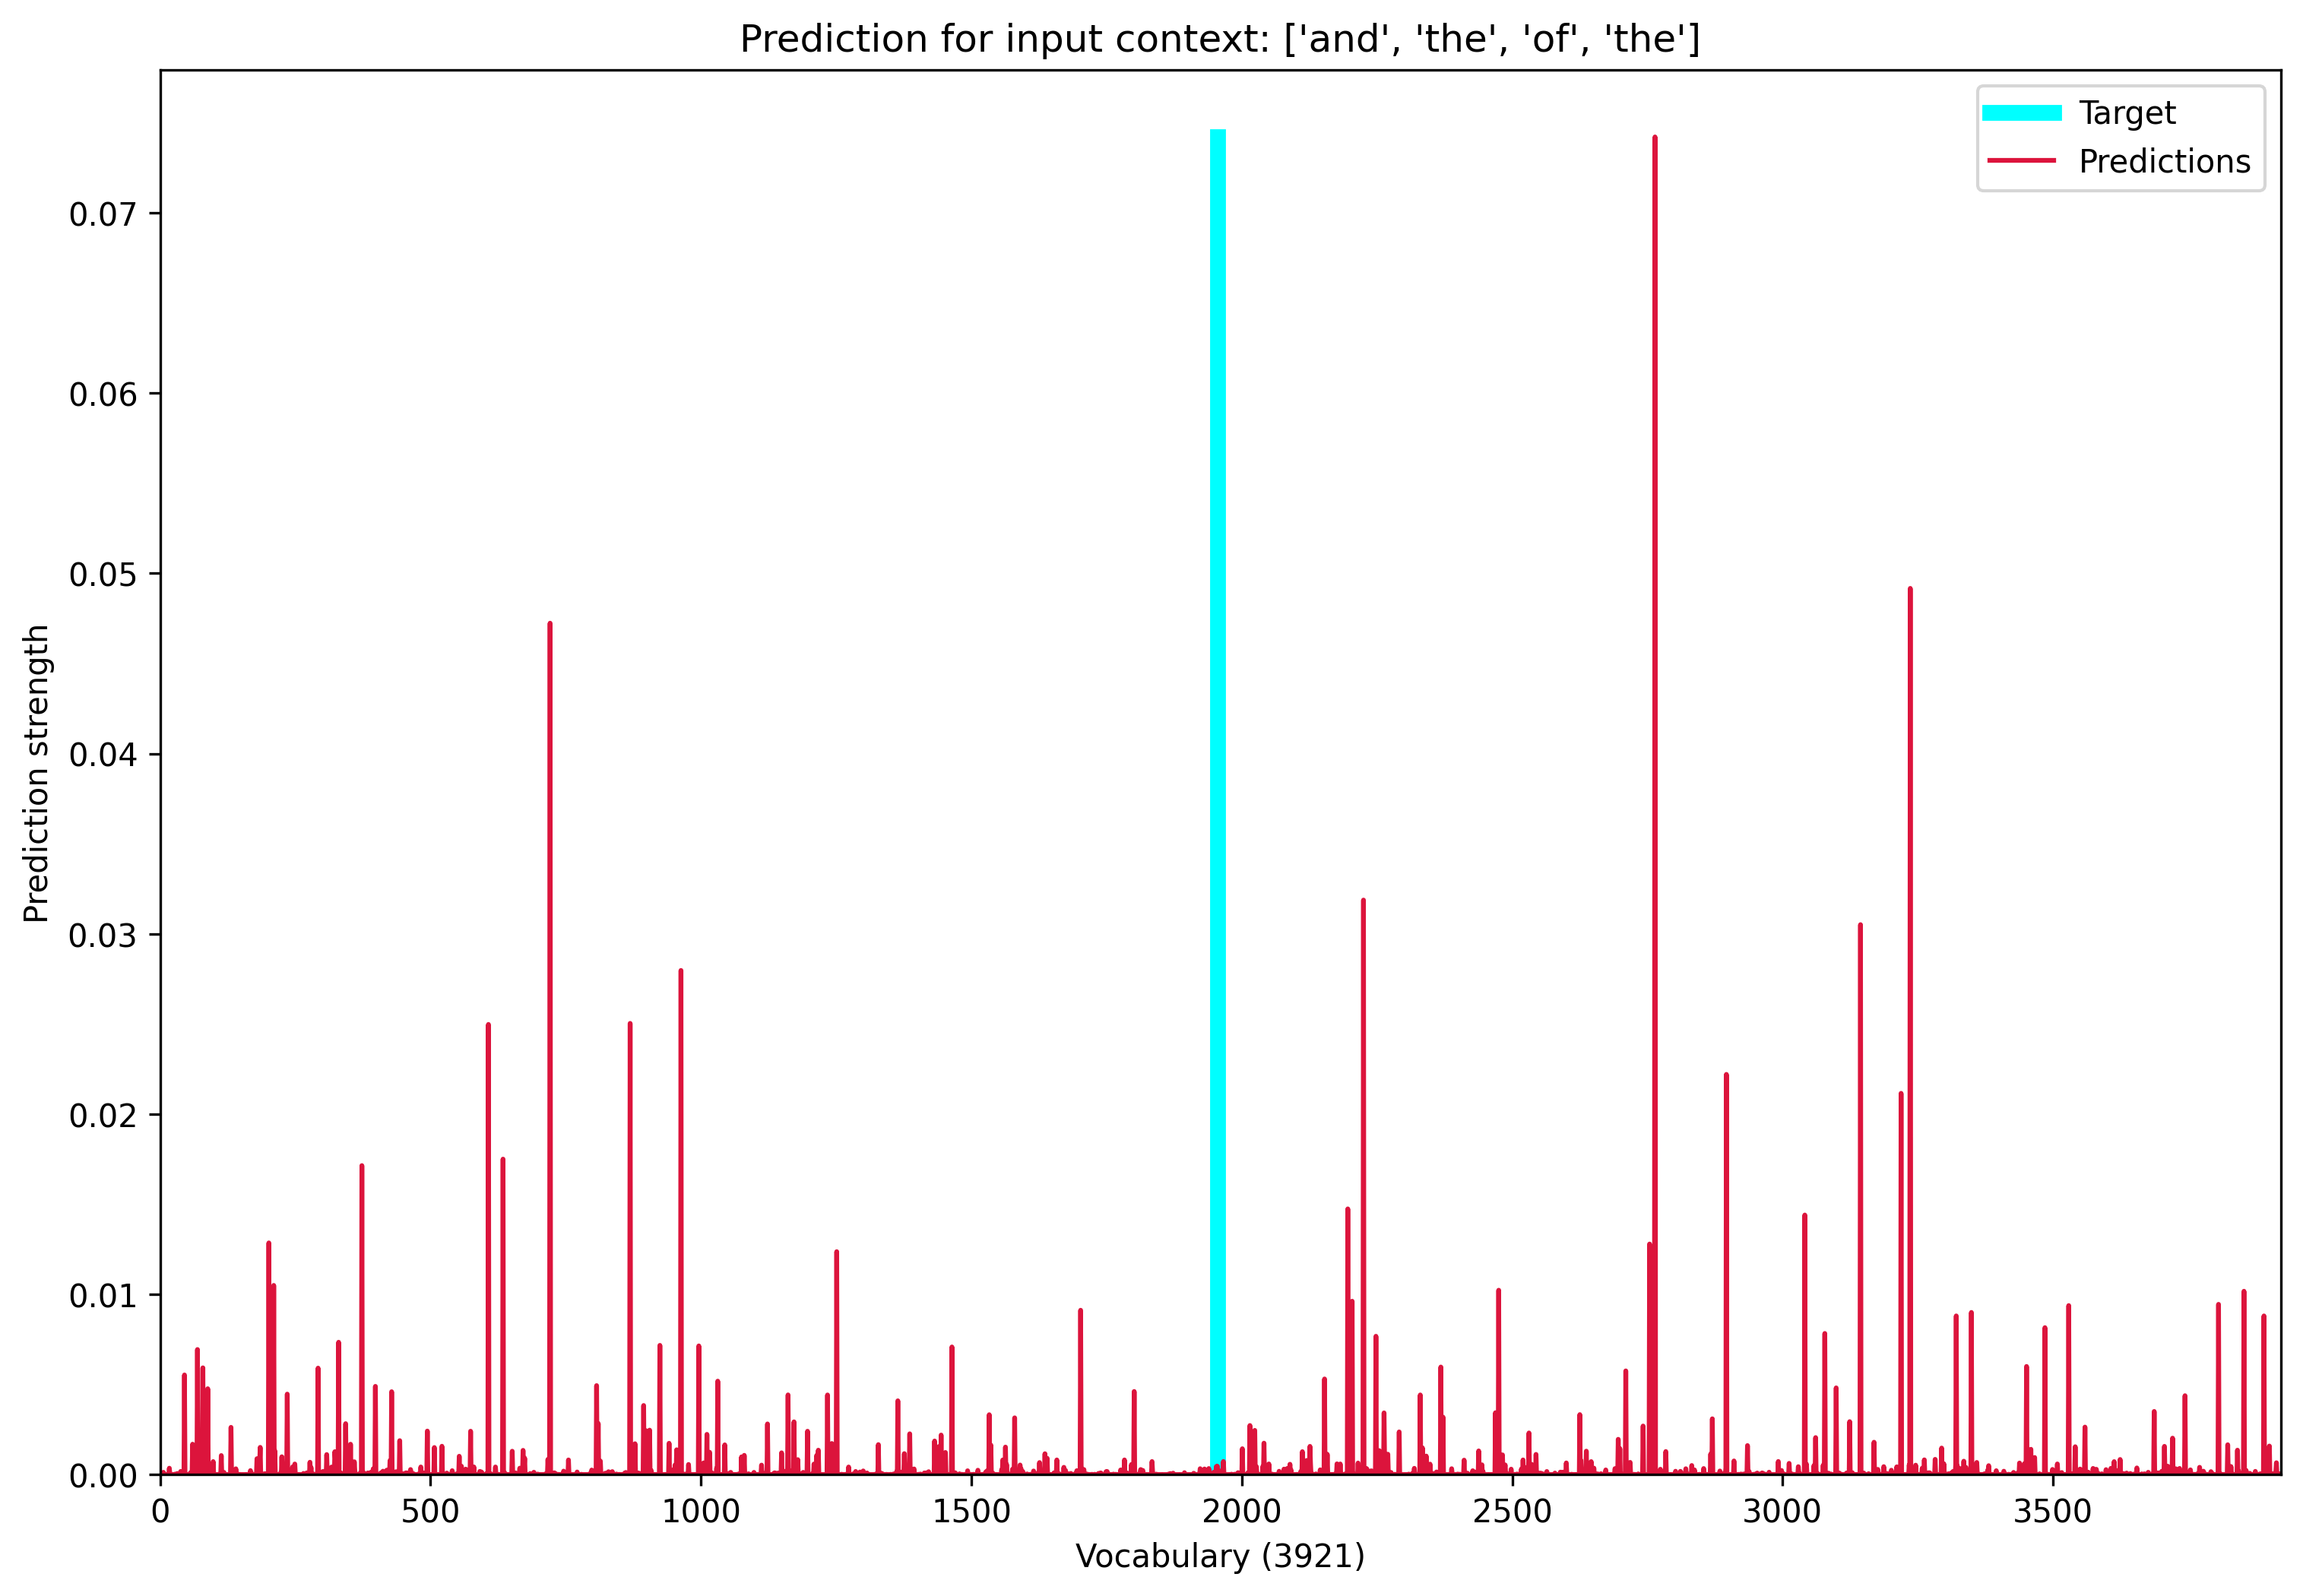

In [22]:
y_max = np.max(predicted_labels)

plt.rcParams["figure.dpi"] = 300
plt.figure(figsize=(12, 8))
plt.plot([input_label, input_label], [0, y_max], color="cyan", linewidth=5, label="Target")
plt.plot(predicted_labels, color="crimson", label="Predictions")
plt.title("Prediction for input context: {}".format([index2word[i] for i in input_context[0]]))
plt.legend()
plt.xlabel("Vocabulary ({})".format(vocabulary_size))
plt.ylabel("Prediction strength")
plt.xlim(0, vocabulary_size)
plt.ylim(0, 1.05 * y_max)
plt.show()

In [23]:
example_words = ["animals", "pigs", "napoleon", "legs", "human", "jones", "farm", "house", "barn", "work", "windmill", "rebellion"]
example_corpus_size = len(example_words)

distance_matrix = np.zeros((example_corpus_size, example_corpus_size))
for i in range(example_corpus_size):
    for j in range(example_corpus_size):
        index_1 = word2index[example_words[i]]
        index_2 = word2index[example_words[j]]
        embedding_1 = word_embeddings[index_1]
        embedding_2 = word_embeddings[index_2]        
        distance_matrix[j, i] = np.linalg.norm(embedding_1 - embedding_2)

In [24]:
similar_pairs_indices = np.zeros((int(example_corpus_size * (example_corpus_size -1)/2), 3))

k = 0
for i in range(example_corpus_size):
    for j in range(i):
        similar_pairs_indices[k, 0] = i
        similar_pairs_indices[k, 1] = j
        similar_pairs_indices[k, 2] = distance_matrix[j, i]
        k += 1

similar_pairs_indices = similar_pairs_indices[np.argsort(similar_pairs_indices[:, -1])]

number_of_examples = 4

print("Strong semantic association")
for k in range(number_of_examples):
    index_1 = int(similar_pairs_indices[k, 0])
    index_2 = int(similar_pairs_indices[k, 1])
    msg = "{}, {} ({:.2f})".format(example_words[index_1], example_words[index_2], distance_matrix[index_2, index_1])
    print(msg)

print("\nWeak semantic association")
for k in range(number_of_examples):
    index_1 = int(similar_pairs_indices[-(1+k), 0])
    index_2 = int(similar_pairs_indices[-(1+k), 1]) 
    msg = "{}, {} ({:.2f})".format(example_words[index_1], example_words[index_2], distance_matrix[index_2, index_1])
    print(msg)

Strong semantic association
windmill, pigs (4.73)
jones, napoleon (5.32)
pigs, animals (5.42)
windmill, animals (5.53)

Weak semantic association
legs, animals (12.23)
jones, human (12.16)
human, napoleon (12.01)
farm, legs (11.98)


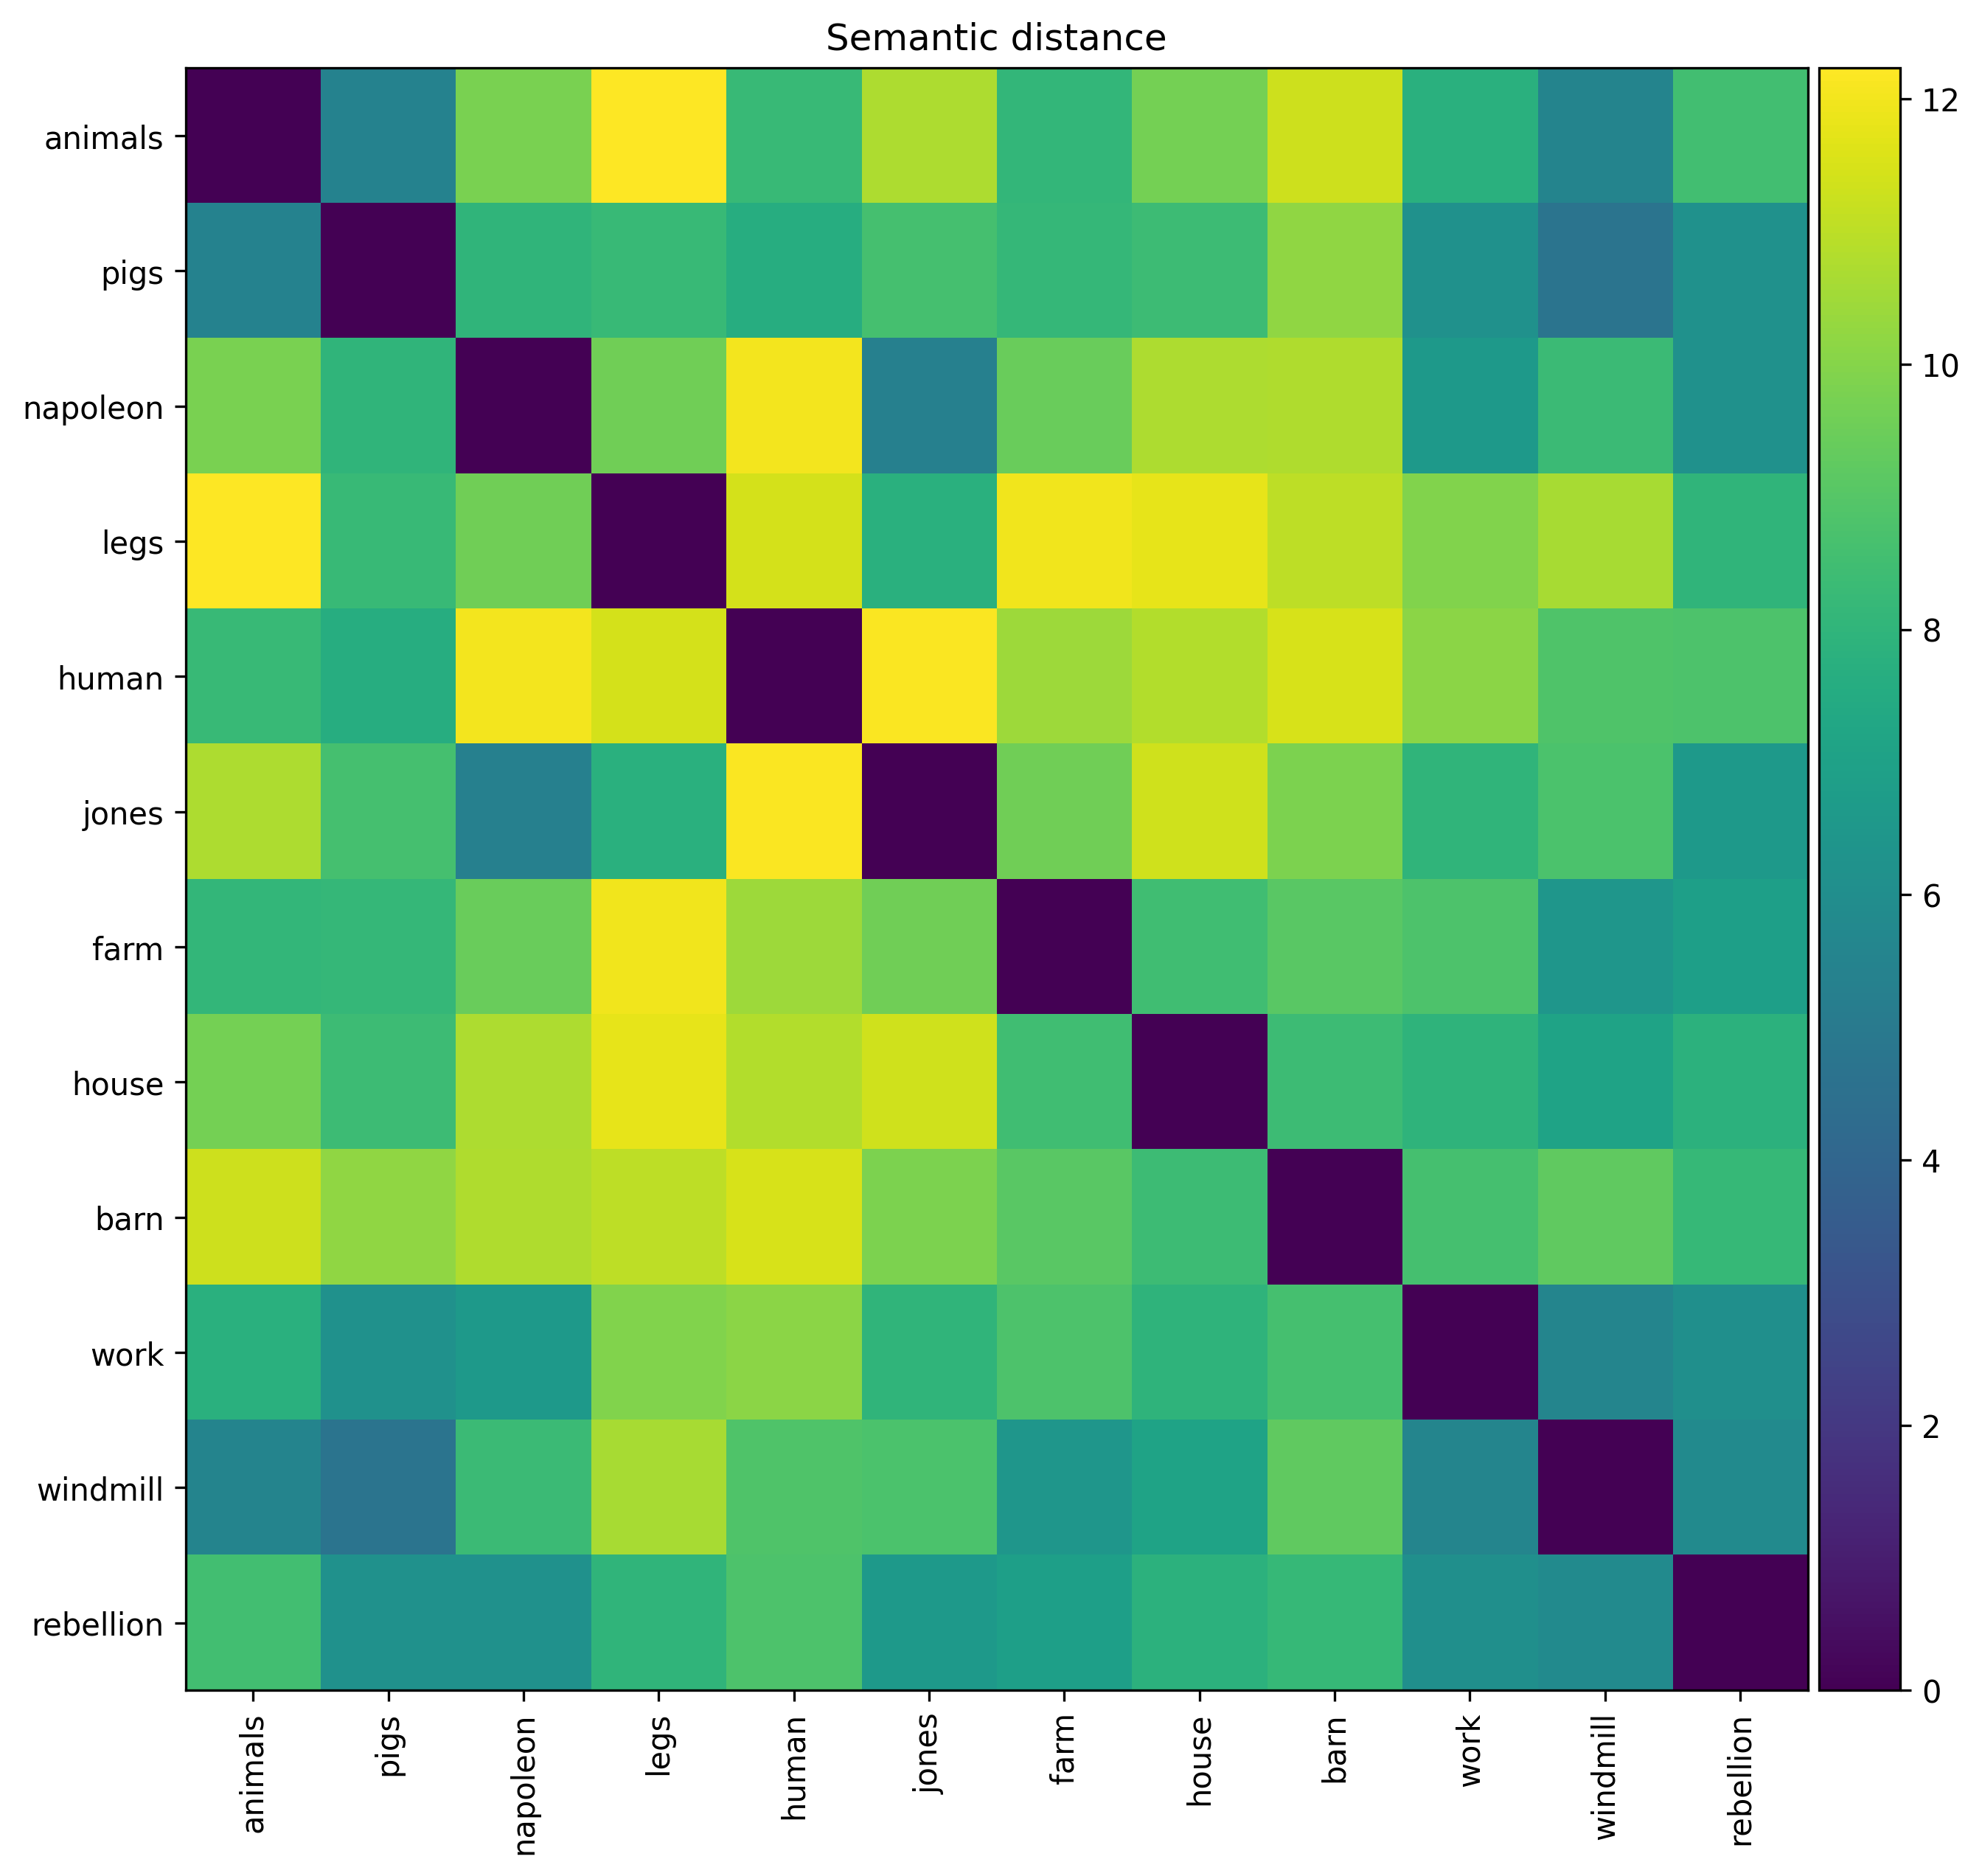

In [26]:
fig, ax = plt.subplots(1)
fig.set_dpi(300)
fig.set_size_inches(10, 10, forward=True)

plt.title("Semantic distance")

im = plt.imshow(distance_matrix)
nice_colorbar(im, ax)

ax.set_xticks(range(example_corpus_size))
ax.set_xticklabels(example_words)
ax.tick_params(axis="x", rotation=90)

ax.set_yticks(range(example_corpus_size))
ax.set_yticklabels(example_words)

plt.show()